In [83]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import acbm
from acbm.validating.plots import plot_comparison, plot_activity_sequence_comparison, plot_intrazonal_trips
from acbm.validating.utils import calculate_od_distances, process_sequences


## Create folder to save plots

In [84]:

# Define the path to the folder you want to create
validation_plots_path = acbm.root_path / "data/processed/plots/validation"
# Create the folder if it does not exist
os.makedirs(validation_plots_path, exist_ok=True)

# Read in the data 

In [85]:
# NTS data 
legs_nts = pd.read_parquet(
    acbm.root_path / "data/external/nts/filtered/nts_trips.parquet"
)

legs_nts = legs_nts[legs_nts["TravDay"] == 3]

# Model outputs 
legs_acbm = pd.read_csv(
    acbm.root_path / "data/processed/activities_pam/legs.csv"
)
legs_acbm_geo = pd.read_parquet(
    acbm.root_path / "data/processed/activities_pam/legs_with_locations.parquet"
)



In [86]:
legs_acbm


,Unnamed: 0,pid,hid,freq,ozone,dzone,purp,origin activity,destination activity,mode,seq,tst,tet,duration
0,0,200,89,NaN,E00059031,E00058877,work,home,work,car,1.0,1900-01-01 12:30:00,1900-01-01 13:00:00,0:30:00
1,1,200,89,NaN,E00059031,E00059031,home,work,home,car,2.0,1900-01-01 16:30:00,1900-01-01 17:00:00,0:30:00
2,2,312,139,NaN,E00059045,E00058294,escort,home,escort,car,1.0,1900-01-01 06:35:00,1900-01-01 06:54:00,0:19:00
3,3,312,139,NaN,E00058294,E00169797,work,escort,work,car,2.0,1900-01-01 06:55:00,1900-01-01 07:22:00,0:27:00
4,4,312,139,NaN,E00059045,E00059045,home,work,home,car,3.0,1900-01-01 18:00:00,1900-01-01 18:35:00,0:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15098,15098,794027,334502,NaN,E00187122,E00057826,home,visit,home,car,4.0,1900-01-01 22:30:00,1900-01-01 22:50:00,0:20:00
15099,15099,794272,334647,NaN,E00170040,E00169786,shop,home,shop,car,1.0,1900-01-01 08:50:00,1900-01-01 09:00:00,0:10:00
15100,15100,794272,334647,NaN,E00169786,E00170040,home,shop,home,car,2.0,1900-01-01 10:20:00,1900-01-01 10:30:00,0:10:00
15101,15101,794273,334647,NaN,E00170040,E00058885,shop,home,shop,car,1.0,1900-01-01 08:50:00,1900-01-01 09:00:00,0:10:00


### Preprocess: Rename columns

In [87]:
# rename origin activity and destination activity columns

legs_acbm = legs_acbm.rename(columns={"origin activity": "oact", "destination activity": "dact"})
legs_acbm_geo = legs_acbm_geo.rename(columns={"origin activity": "oact", "destination activity": "dact"})


# rename distance column in NTS
legs_nts = legs_nts.rename(columns={"TripDisIncSW": "distance"})

### Preprocess: Edit distance column

The NTS distance is in miles, but the distance we are using for acbm is kms. Convert the NTS distance to kms.

In [88]:
# convert legs_nts["distance"] from miles to km

legs_nts["distance"] = legs_nts["distance"] * 1.60934

### Preprocess: Add columns

In [89]:
# Create hour column 

# acbm - tst is in datetime format
# Convert tst to datetime format and extract the hour component in one step
legs_acbm['tst_hour'] = legs_acbm['tst'].apply(lambda x: pd.to_datetime(x).hour)
legs_acbm['tet_hour'] = legs_acbm['tet'].apply(lambda x: pd.to_datetime(x).hour)

# nts - tst is in minutes
# Convert legs_nts["tst"] from minutes to hours
legs_nts['tst_hour'] = legs_nts['tst'] // 60
legs_nts['tet_hour'] = legs_nts['tet'] // 60

In [90]:

legs_nts[
    [
        "seq",
        "ozone",
        "dzone",
        "oact",
        "dact",
        "mode",
        "tst",
        "tet",
        "tst_hour",
        "tet_hour",
    ]
]

,seq,ozone,dzone,oact,dact,mode,tst,tet,tst_hour,tet_hour
4659590,3,8,8.0,shop,home,car,795.0,810.0,13.0,13.0
4659597,1,2,2.0,home,medical,car,505.0,525.0,8.0,8.0
4659609,1,8,7.0,home,work,pt,445.0,556.0,7.0,9.0
4659616,1,8,8.0,home,other,car,720.0,750.0,12.0,12.0
4659617,3,8,8.0,visit,home,car,985.0,1041.0,16.0,17.0
...,...,...,...,...,...,...,...,...,...,...
5150053,6,9,9.0,escort,home,car,1020.0,1035.0,17.0,17.0
5150079,1,9,8.0,home,education,car,480.0,525.0,8.0,8.0
5150080,2,8,9.0,education,home,car,965.0,1035.0,16.0,17.0
5150098,1,9,9.0,home,shop,car,645.0,660.0,10.0,11.0


In [8]:
# # add a column in legs_acbm to identify whether the trip is a primary or secondary trip

# # Define the conditions for primary trips
# conditions_primary = (
#     ((legs_acbm['oact'] == 'home') & (legs_acbm['dact'].isin(['work', 'education']))) |
#     ((legs_acbm['oact'].isin(['work', 'education'])) & (legs_acbm['dact'] == 'home'))
# )

# # Add the trip_type column
# legs_acbm['trip_type'] = np.where(conditions_primary, 'primary', 'secondary')

# # Print the resulting DataFrame to verify
# print(legs_acbm[['oact', 'dact', 'trip_type']].head())

     oact    dact  trip_type
0    home    work    primary
1    work    home    primary
2    home  escort  secondary
3  escort    work  secondary
4    work    home    primary


### Preprocess: Abbreviate trip purpose columns

In [91]:
# Mapping dictionary
activity_mapping = {
    "home": "h",
    "other": "o",
    "escort": "e",
    "work": "w",
    "shop": "sh",
    "visit": "v",
    "education": "edu",
    "medical": "m",
}

legs_acbm["oact_abr"] = legs_acbm["oact"].replace(activity_mapping)
legs_acbm["dact_abr"] = legs_acbm["dact"].replace(activity_mapping)

legs_nts["oact_abr"] = legs_nts["oact"].replace(activity_mapping)
legs_nts["dact_abr"] = legs_nts["dact"].replace(activity_mapping)

# Compare distributions between NTS and output

# Matching 

## Matching: Trip Purpose 

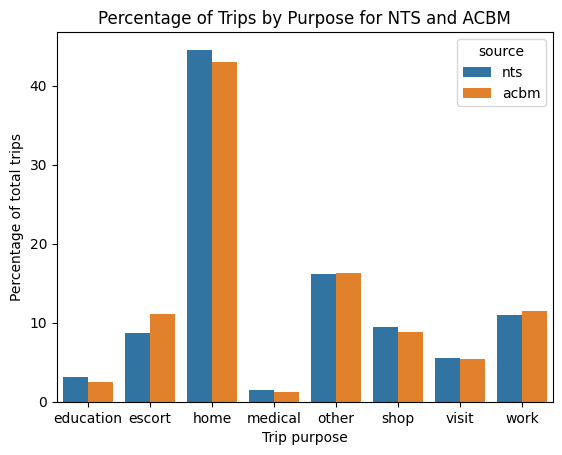

In [92]:
# Get number of trips by mode for legs_nts, and legs_acbm, and plot a comparative bar plot

# NTS
purpose_nts = legs_nts.groupby("dact").size().reset_index(name="count")
purpose_nts["source"] = "nts"

# ACBM
purpose_acbm = legs_acbm.groupby("dact").size().reset_index(name="count")
purpose_acbm["source"] = "acbm"

# Combine the data
purpose_compare = pd.concat([purpose_nts, purpose_acbm])

# Calculate the percentage of trips for each mode within each source
purpose_compare["percentage"] = purpose_compare.groupby("source")["count"].transform(lambda x: (x / x.sum()) * 100)


sns.barplot(data=purpose_compare, x="dact", y="percentage", hue="source")
plt.xlabel('Trip purpose')
plt.ylabel('Percentage of total trips')
plt.title('Percentage of Trips by Purpose for NTS and ACBM')
plt.show()

## Matching: Trip Mode 



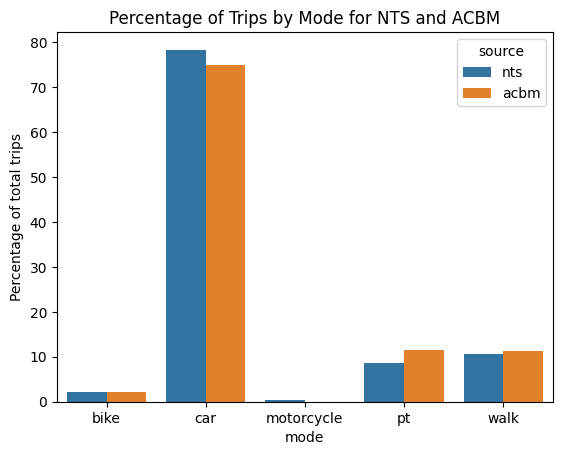

In [93]:
# Get number of trips by mode for legs_nts, and legs_acbm, and plot a comparative bar plot

# NTS
modeshare_nts = legs_nts.groupby("mode").size().reset_index(name="count")
modeshare_nts["source"] = "nts"

# ACBM
modeshare_acbm = legs_acbm.groupby("mode").size().reset_index(name="count")
modeshare_acbm["source"] = "acbm"

# Combine the data
modeshare_compare = pd.concat([modeshare_nts, modeshare_acbm])

# Calculate the percentage of trips for each mode within each source
modeshare_compare["percentage"] = modeshare_compare.groupby("source")["count"].transform(lambda x: (x / x.sum()) * 100)


sns.barplot(data=modeshare_compare, x="mode", y="percentage", hue="source")
plt.ylabel('Percentage of total trips')
plt.title('Percentage of Trips by Mode for NTS and ACBM')
plt.show()

## Matching: Time of Day 

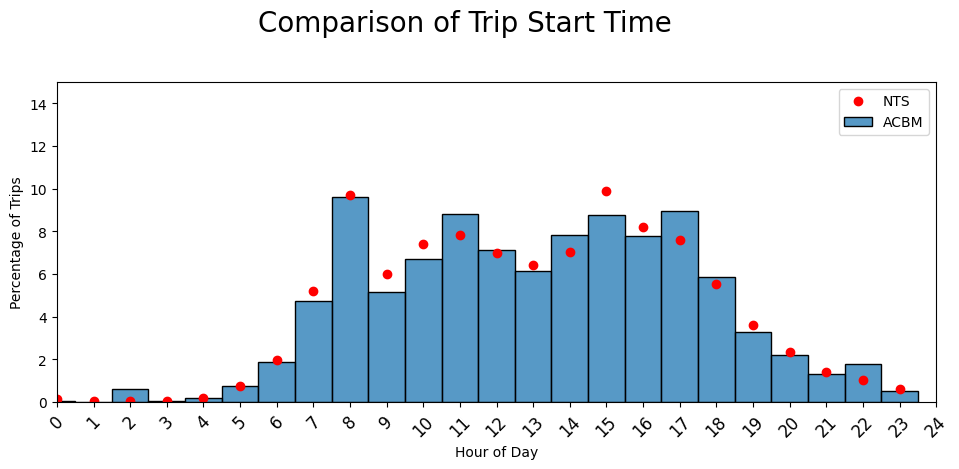

In [94]:
# Plot aggregate
plot_comparison(
    legs_acbm,
    legs_nts,
    value_column="tst_hour",
    max_y_value=15,
    plot_type="time",
    figsize=(10, 5),
    plot_mode="aggregate",
)

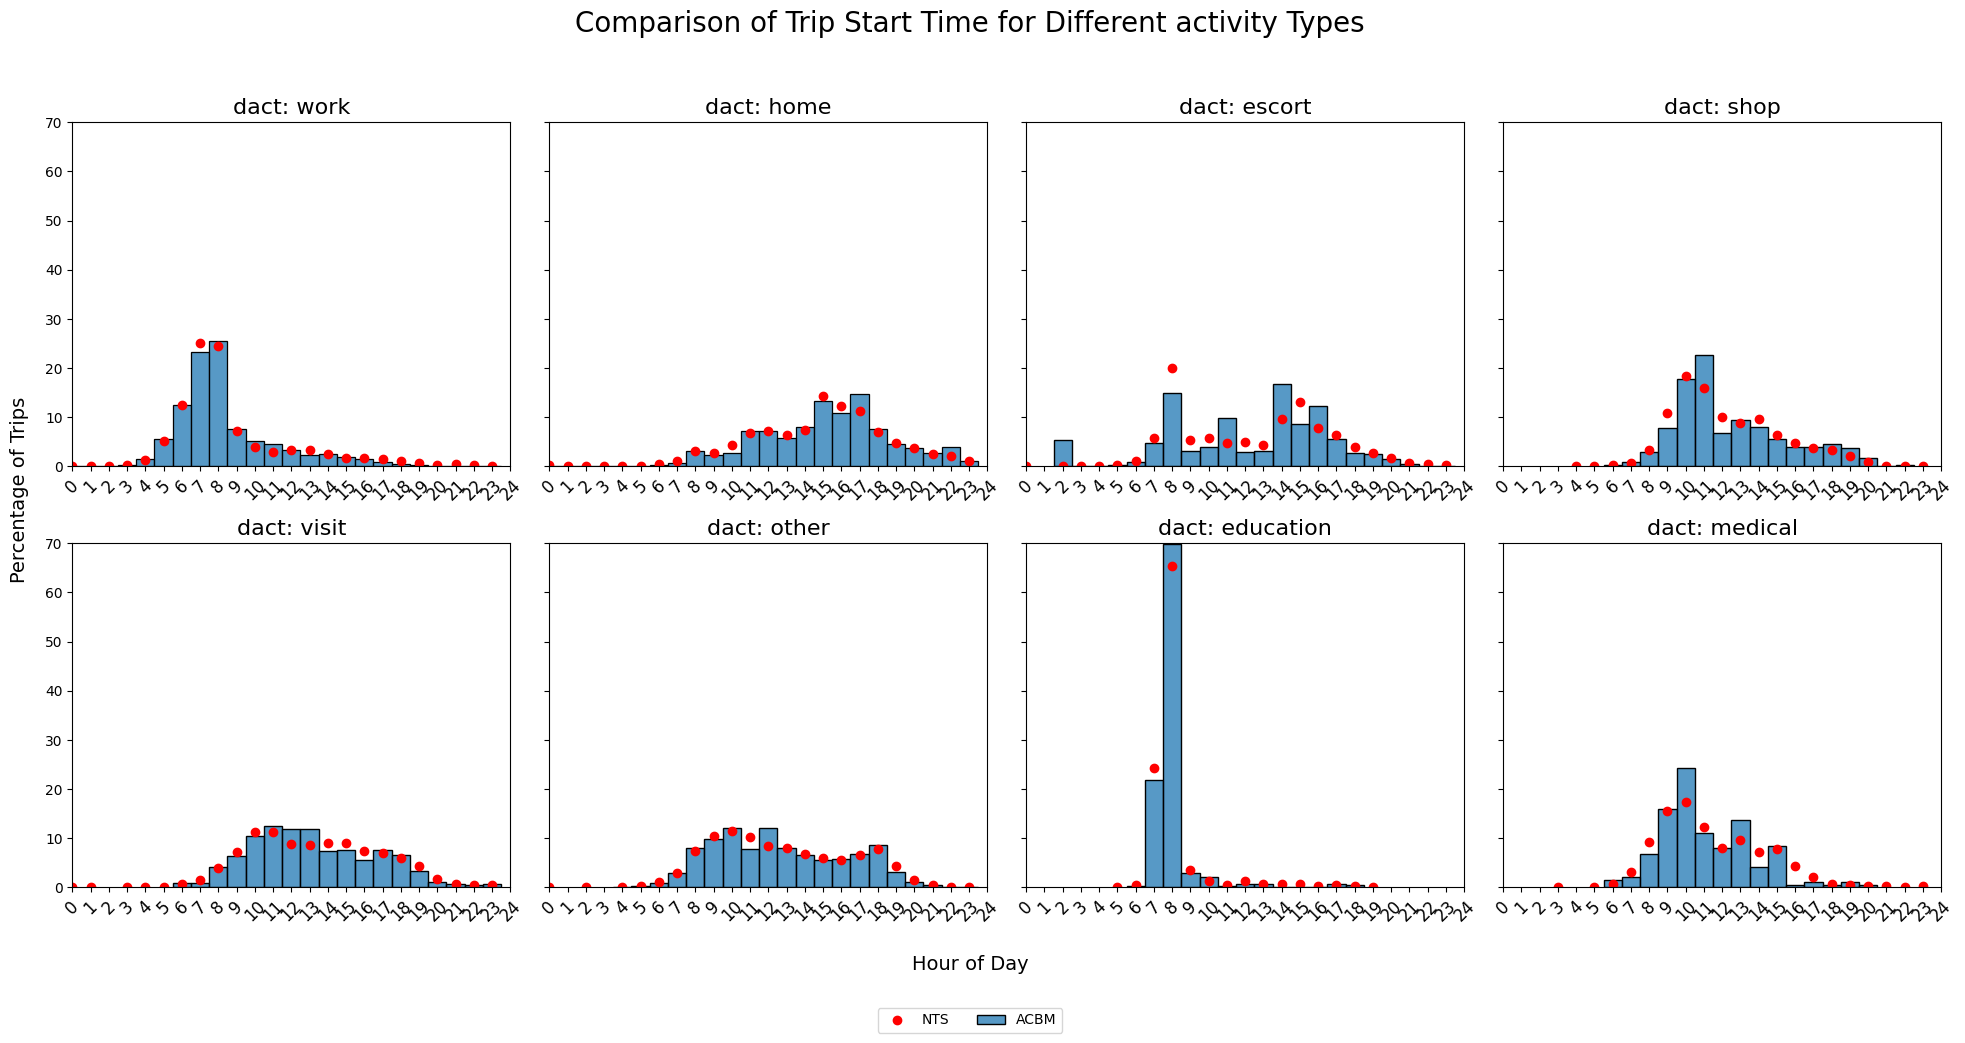

In [95]:
# Plot facet
plot_comparison(
    legs_acbm,
    legs_nts,
    value_column="tst_hour",
    max_y_value=70,
    plot_type="time",
    plot_mode="facet",
)

## Matching: Activity Sequences

Create chains from data and count number of observations of each chain

In [96]:
sequence_nts = process_sequences(
    df=legs_nts,
    pid_col="IndividualID",
    seq_col="seq",
    origin_activity_col="oact_abr",
    destination_activity_col="dact_abr",
    suffix="nts",
)

sequence_nts

,activity_sequence,count_nts
0,e - e - e - h - e - e - v - v - h - e - h,1
1,e - e - e - h - o - h,1
2,e - e - h,1
3,e - h,10
4,e - h - e,3
...,...,...
1818,w - w - w - h - o - h - o - h,1
1819,w - w - w - h - w - w - h - w - h,1
1820,w - w - w - sh - w,1
1821,w - w - w - w - h - h - h - w,1


In [97]:
sequence_acbm = process_sequences(
    df=legs_acbm,
    pid_col="pid",
    seq_col="seq",
    origin_activity_col="oact_abr",
    destination_activity_col="dact_abr",
    suffix="acbm",
)

sequence_acbm
                                  

,activity_sequence,count_acbm
0,h - e,5
1,h - e - e - e,1
2,h - e - e - e - h,96
3,h - e - e - e - o - v - h,1
4,h - e - e - e - sh - h - v - h,1
...,...,...
486,h - w - w - w - w - h,3
487,h - w - w - w - w - h - o - h,1
488,h - w - w - w - w - h - w - w - w - w - h,1
489,h - w - w - w - w - w - h,1


Plot the comparison

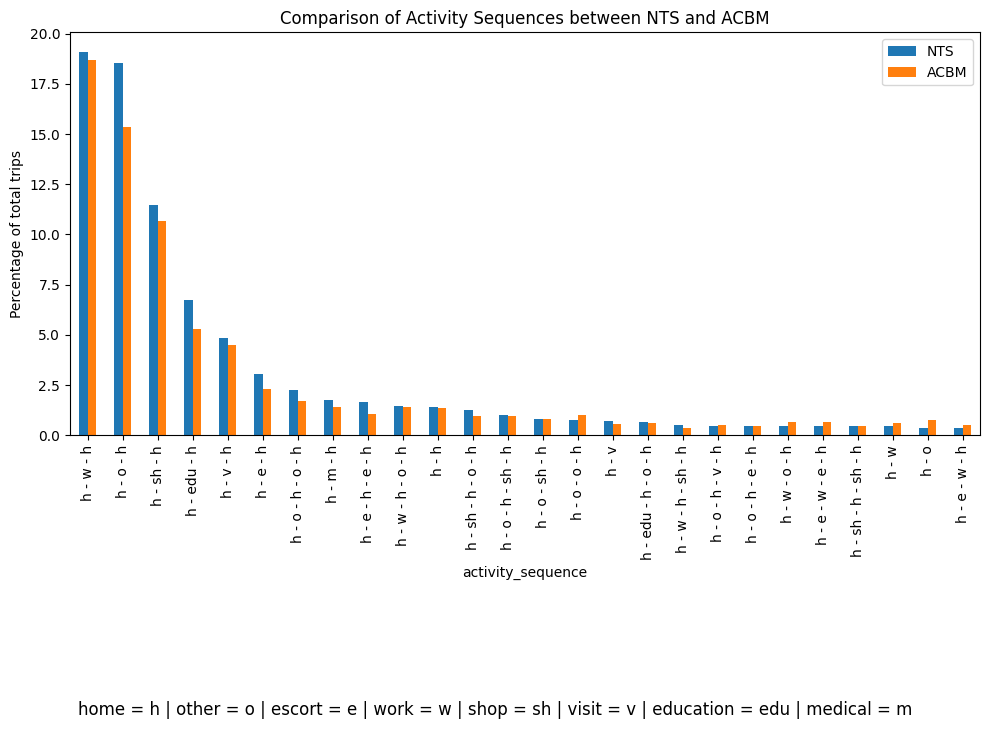

In [98]:
plot_activity_sequence_comparison(
    sequence_nts=sequence_nts,
    sequence_acbm=sequence_acbm,
    activity_mapping=activity_mapping,
    perc_cutoff=0.35,
    #save_path=validation_plots_path / "4_matching_activity_sequences.png",
)

## Assigning: Trip distances

### Mean crowfly distance per trip purpose

Calculate travel distance for acbm activities

In [99]:
# Apply the function to legs_acbm_geo
legs_acbm_geo = calculate_od_distances(
    df=legs_acbm_geo,
    start_wkt_col="start_location_geometry_wkt",
    end_wkt_col="end_location_geometry_wkt",
)

legs_acbm_geo.head(10)

,pid,hid,ozone,dzone,purp,oact,dact,mode,seq,tst,tet,duration,start_location_id,end_location_id,start_location_geometry_wkt,end_location_geometry_wkt,start_geometry,end_geometry,distance
0,200,89,E00059031,E00058877,work,home,work,car,1.0,1900-01-01 12:30:00,1900-01-01 13:00:00,0:30:00,1735597748,284127794,POINT (-1.399263822377326 53.934588245650026),POINT (-1.5223977194364153 53.80563634318617),POINT (-155765.336 7157777.811),POINT (-1.5223977194364153 53.80563634318617),27.9
1,200,89,E00059031,E00059031,home,work,home,car,2.0,1900-01-01 16:30:00,1900-01-01 17:00:00,0:30:00,284127794,1735597748,POINT (-1.5223977194364153 53.80563634318617),POINT (-1.399263822377326 53.934588245650026),POINT (-169472.539 7133431.742),POINT (-1.399263822377326 53.934588245650026),27.9
2,312,139,E00059045,E00058294,escort,home,escort,car,1.0,1900-01-01 06:35:00,1900-01-01 06:54:00,0:19:00,1750466246,1325685728,POINT (-1.4001307419061457 53.927941746853776),POINT (-1.5100280118435312 53.89948871840075),POINT (-155861.841 7156521.118),POINT (-1.5100280118435312 53.89948871840075),13.4
3,312,139,E00058294,E00169797,work,escort,work,car,2.0,1900-01-01 06:55:00,1900-01-01 07:22:00,0:27:00,1325685728,443167284,POINT (-1.5100280118435312 53.89948871840075),POINT (-1.5484560286132372 53.797016858417656),POINT (-168095.549 7151143.595),POINT (-1.5484560286132372 53.797016858417656),19.8
4,312,139,E00059045,E00059045,home,work,home,car,3.0,1900-01-01 18:00:00,1900-01-01 18:35:00,0:35:00,443167284,1750466246,POINT (-1.5484560286132372 53.797016858417656),POINT (-1.4001307419061457 53.927941746853776),POINT (-172373.337 7131807.059),POINT (-1.4001307419061457 53.927941746853776),29.7
5,312,139,E00059045,E00059120,shop,home,shop,car,4.0,1900-01-01 19:00:00,1900-01-01 19:10:00,0:10:00,1750466246,1065505008,POINT (-1.4001307419061457 53.927941746853776),POINT (-1.5891715167646434 53.78010086020202),POINT (-155861.841 7156521.118),POINT (-1.5891715167646434 53.78010086020202),34.9
6,312,139,E00059120,E00059045,home,shop,home,car,5.0,1900-01-01 19:40:00,1900-01-01 19:45:00,0:05:00,1065505008,1750466246,POINT (-1.5891715167646434 53.78010086020202),POINT (-1.4001307419061457 53.927941746853776),POINT (-176905.764 7128619.540),POINT (-1.4001307419061457 53.927941746853776),34.9
7,313,139,E00059045,E00057830,work,home,work,car,1.0,1900-01-01 06:35:00,1900-01-01 06:54:00,0:19:00,1750466246,446256422,POINT (-1.4001307419061457 53.927941746853776),POINT (-1.4996387249709981 53.76805382233579),POINT (-155861.841 7156521.118),POINT (-1.4996387249709981 53.76805382233579),32.1
8,313,139,E00059045,E00059045,home,work,home,pt,2.0,1900-01-01 18:00:00,1900-01-01 18:20:00,0:20:00,446256422,1750466246,POINT (-1.4996387249709981 53.76805382233579),POINT (-1.4001307419061457 53.927941746853776),POINT (-166939.019 7126350.273),POINT (-1.4001307419061457 53.927941746853776),32.1
9,313,139,E00059045,E00169811,shop,home,shop,car,3.0,1900-01-01 19:00:00,1900-01-01 19:10:00,0:10:00,1750466246,443167282,POINT (-1.4001307419061457 53.927941746853776),POINT (-1.5489307938428294 53.796367947390756),POINT (-155861.841 7156521.118),POINT (-1.5489307938428294 53.796367947390756),29.9


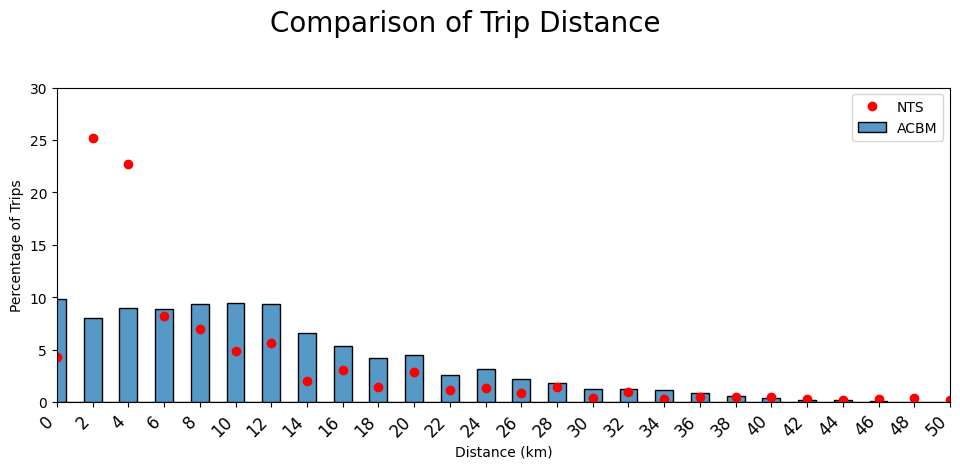

In [100]:
# Plot: Aggregate
plot_comparison(
    legs_acbm_geo,
    legs_nts,
    value_column="distance",
    bin_size=2,
    value_threshold=50,
    max_y_value=30,
    figsize=(10, 5),
    plot_type="distance",
    plot_mode="aggregate",
    )

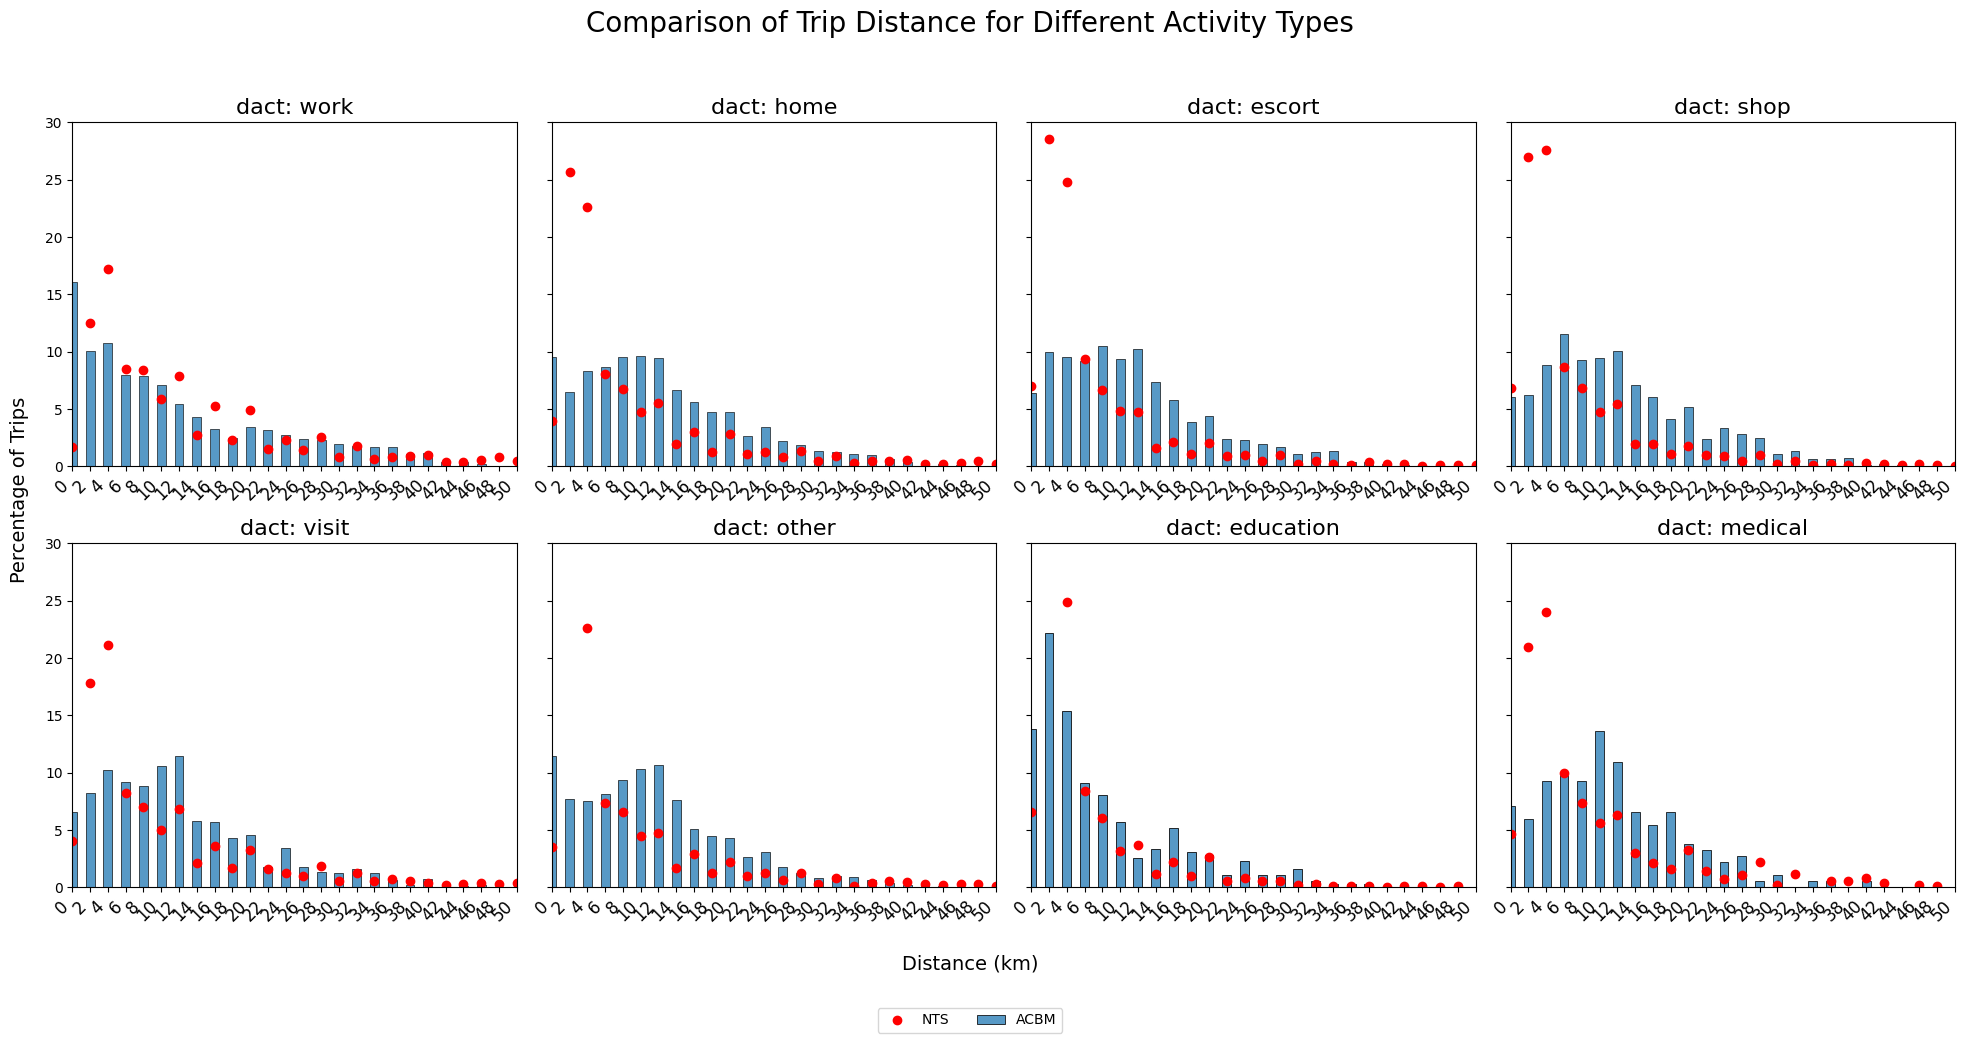

In [101]:
# Plot: Facet by activity_type
plot_comparison(
    legs_acbm_geo,
    legs_nts,
    value_column="distance",
    bin_size=2,
    value_threshold=50,
    max_y_value=30,
    plot_type="distance",
    plot_mode="facet",
)

### Test number of intrazonal trips

To ensure that our intrazonal logic is working. It appears we are underestimating the number of trips that are 2-4km and 4-6km. 

This could also be a result of travel times not correlating directly with distance, and that effect being more pronounced in shorter trips.


#### Plot intrazonal trips by trip purpose

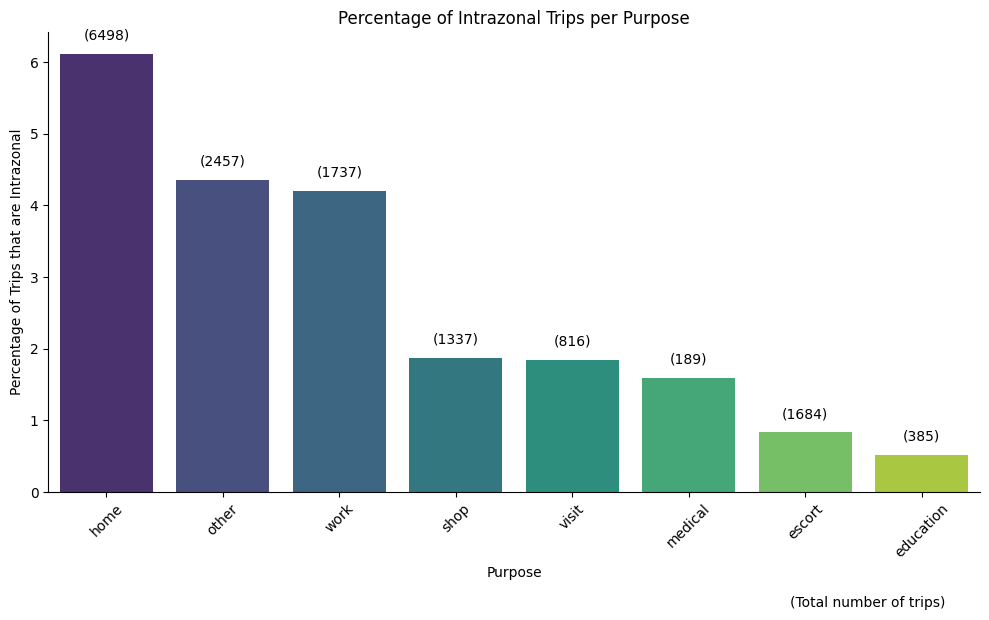

In [102]:
# Calculate the percentage of intrazonal trips for each unique purpose
plot_intrazonal_trips(
    legs_acbm,
    validation_plots_path=validation_plots_path,
    plot_type="purp",
)

#### Plot intrazonal trips by OD pair

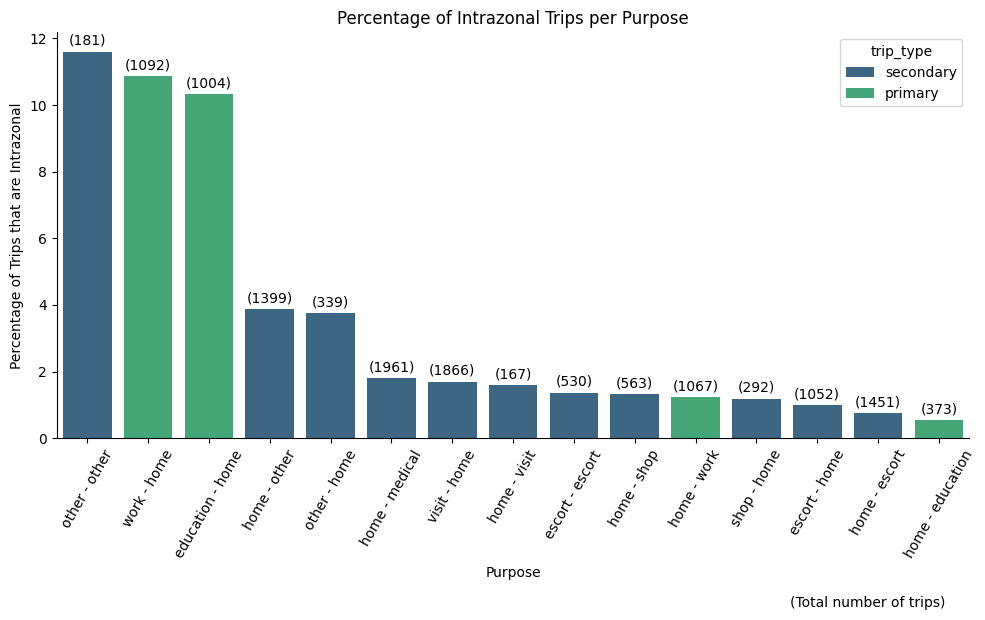

In [104]:
# Calculate the percentage of intrazonal trips for each unique OD combination
# (e.g. home - work)
plot_intrazonal_trips(
    legs_acbm,
    validation_plots_path=validation_plots_path,
    plot_type="od",
)


TODO: Remove later

Check if total trips FROM and TO each activity are the same


In [42]:
# ACBM: Check if total trips FROM and TO each activity are the same

# Group by 'oact' and and calculate the total number of trips
total_trips_from = legs_acbm.groupby(['oact']).size().reset_index(name='total_trips_from')
# rename oact to activity
total_trips_from = total_trips_from.rename(columns={'oact': 'activity'})
total_trips_from

# Group by 'dact' and and calculate the total number of trips
total_trips_to = legs_acbm.groupby(['dact']).size().reset_index(name='total_trips_to')
# rename dact to activity
total_trips_to = total_trips_to.rename(columns={'dact': 'activity'})

# Merge the two DataFrames
total_trips = pd.merge(total_trips_from, total_trips_to, on='activity', how='outer')

total_trips


,activity,total_trips_from,total_trips_to
0,education,373,385
1,escort,1673,1684
2,home,6752,6498
3,medical,183,189
4,other,2389,2457
5,shop,1318,1337
6,visit,716,816
7,work,1699,1737


In [43]:
# NTS: Check if total trips FROM and TO each activity are the same

# Group by 'oact' and and calculate the total number of trips
total_trips_from = legs_nts.groupby(['oact']).size().reset_index(name='total_trips_from')
# rename oact to activity
total_trips_from = total_trips_from.rename(columns={'oact': 'activity'})
total_trips_from

# Group by 'dact' and and calculate the total number of trips
total_trips_to = legs_nts.groupby(['dact']).size().reset_index(name='total_trips_to')
# rename dact to activity
total_trips_to = total_trips_to.rename(columns={'dact': 'activity'})

# Merge the two DataFrames
total_trips = pd.merge(total_trips_from, total_trips_to, on='activity', how='outer')

total_trips

,activity,total_trips_from,total_trips_to
0,education,1796,1823
1,escort,5158,5180
2,home,26573,26434
3,medical,850,859
4,other,9610,9628
5,shop,5633,5621
6,visit,3212,3313
7,work,6527,6501


### Crowfly distance cumulative chart (KM distance vs. % of trips)